In [1]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

!python -m spacy download en_core_web_lg
import spacy 
import en_core_web_lg
nlp = en_core_web_lg.load()
from spacy.lang.en import English
parser = English()

import base64
import string
punctuations = string.punctuation
import re

!pip install docx2txt
import docx2txt

#Pre-Processing libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


#Machine Learning Models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 827.9MB 1.5MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=13eb7e096b03d3fc7213a4476da4e0bfc05c10042674d10f72ba4ec2ec9719e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-1s04d22f/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
  Created wheel for docx2txt: filename=docx2txt-0.8-cp36-none-any.whl size=3965 sha256=139aab9ccbc18643faccb16ad0055da91eb2ec97537b9838f1068fbe77ac072c
  Stored in directory: /root/.cache/pip/wheels/b2/1f/26/a051209bbb77fc6bcfae2bb7e01fa0ff941b82292ab084d596
Successfully built docx2txt


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#reading data
df = pd.read_csv('/content/Preprocessed_data.csv')

In [3]:
#visualizing data
df.head()

,Unnamed: 0,title,description,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,city,country_name
0,2,Piping Material Engineer,Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States
1,3,"Discipline Manager Civil, Structural, Marine...",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Professional,Oil & Energy,Engineering,1,Houston,United States
2,4,FEA Senior engineer,Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States
3,9,AUTOCAD OPERATOR,Responsibilities:Using a project database syst...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Staffing and Recruiting,Engineering,0,Cebu,Philippines
4,13,Accounting Clerk,"Job DescriptionVerify, obtain approvals and pa...",0,1,1,Full-time,Associate,High School or equivalent,Accounting,Customer Service,1,AUSTIN,United States


In [4]:
# Removing irrelevant column
del df['Unnamed: 0']

In [5]:
#checking for null values
df.isnull().sum()

title                  0
description            0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
city                   0
country_name           0
dtype: int64

In [6]:
df1 = df.copy()

## Final Data Clean

In [7]:
STOPLIST = set(stopwords + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ")

In [8]:
def tokenizetext(sample):
    text = sample.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    tokens = parser(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [9]:
vectorizer = CountVectorizer(tokenizer = tokenizetext, ngram_range = (1,3), min_df = 0.06)

In [10]:
vectorizer_features = vectorizer.fit_transform(df1['description'])

In [11]:
vectorizer_features.shape

(11272, 666)

In [12]:
vectorizer_features

<11272x666 sparse matrix of type '<class 'numpy.int64'>'
	with 991737 stored elements in Compressed Sparse Row format>

In [13]:
vectorized_df = pd.DataFrame(vectorizer_features.todense(), columns = vectorizer.get_feature_names())
df_vectorized = pd.concat([df1, vectorized_df], axis = 1)

In [14]:
df_vectorized.drop('description', axis = 1, inplace = True)
df_vectorized.dropna(inplace=True)

In [15]:
df_vectorized.head()

,title,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,city,country_name,,experience,looking,tefl,tefl tesol,'s,1,10,100,2,2 years,200,200 cost,3,3 years,30,4,5,5 years,6,:),ability,ability work,able,abroad,abroad :),access,account,...,usd monthly 200,use,used,user,users,using,value,values,variety,various,verbal,verbal written,vision,volume,want,way,web,website,week,wide,willing,windows,word,work,work closely,working,world,writing,written,written communication,written verbal,year,years,years experience,york,–,’,’s,“,”
0,Piping Material Engineer,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
1,"Discipline Manager Civil, Structural, Marine...",0,1,0,Full-time,Entry level,Professional,Oil & Energy,Engineering,1,Houston,United States,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,FEA Senior engineer,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,AUTOCAD OPERATOR,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Staffing and Recruiting,Engineering,0,Cebu,Philippines,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0
4,Accounting Clerk,0,1,1,Full-time,Associate,High School or equivalent,Accounting,Customer Service,1,AUSTIN,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0


In [16]:
columns_to_1_hot = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

for column in columns_to_1_hot:
    encoded = pd.get_dummies(df_vectorized[column])
    df_vectorized = pd.concat([df_vectorized, encoded], axis = 1)

In [17]:
columns_to_1_hot += ['title', 'city', 'country_name']
df_vectorized.drop(columns_to_1_hot, axis = 1, inplace = True)

In [18]:
target = df_vectorized['fraudulent']
features = df_vectorized.drop('fraudulent', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, stratify = target, random_state=42)

In [19]:
print(X_train.shape)
print(X_test.shape)

(10144, 857)
(1128, 857)


## Evaluating Different models for Fraudulent Job Filter

In [20]:
Model_Score = []
Model_Name = []

## 1. Logistic Regression

In [21]:
log_reg = LogisticRegression()
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty_options = ['l1', 'l2']

param_grid = dict(C = c_values, penalty = penalty_options)

#Finding best parameters
grid_tfidf = GridSearchCV(log_reg, param_grid = param_grid, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose=1)

#Training the model
grid_tfidf.fit(X_train, y_train)

#Best parameters
print("Best Score" , grid_tfidf.best_score_)
print("Best Parameter" , grid_tfidf.best_params_)

#Predicting
log_reg_pred = grid_tfidf.predict(X_test)
print("ROC Score" , roc_auc_score(y_test, log_reg_pred))

#Appending for Model Comparison
Model_Name.append('Logistic_Regression')
Model_Score.append(round(roc_auc_score(y_test, log_reg_pred), 4))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished


Best Score 0.9885987106336861
Best Parameter {'C': 0.1, 'penalty': 'l2'}
ROC Score 0.7795466908431551


## 2. KNN

In [22]:
knn = KNeighborsClassifier()
k_range = list(np.arange(2, 23, 2))
param_grid_knn = dict(n_neighbors = k_range)

#Finding best parameters
grid_knn = GridSearchCV(knn, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

#Training the model
grid_knn.fit(X_train, y_train)

#Best parameters
print("Best Score" , grid_knn.best_score_)
print("Best parameter" ,grid_knn.best_params_)

#Predicting
knn_pred = grid_knn.predict(X_test)
print("ROC Score" , roc_auc_score(y_test, knn_pred))

#Appending for Model Comparison
Model_Name.append('KNN')
Model_Score.append(round(roc_auc_score(y_test, knn_pred), 4))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 20.4min finished


Best Score 0.9612380267435932
Best parameter {'n_neighbors': 22}
ROC Score 0.6


## 3. SVC

In [23]:
svc = SVC()
kernel = ['linear', 'rbf']
param_grid_knn = dict(kernel = kernel)

#Finding best parameters
grid_svc = GridSearchCV(svc, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 2)

#Training the model
grid_svc.fit(X_train, y_train)

#Best parameters
print("Best Score" , grid_svc.best_score_)
print("Best Parameter" ,grid_svc.best_params_)

#Predicting
svc_pred = grid_svc.predict(X_test)
print("ROC Score" , roc_auc_score(y_test, svc_pred))

#Appending for Model Comparison
Model_Name.append('SVC')
Model_Score.append(round(roc_auc_score(y_test, svc_pred), 4))


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


Best Score 0.9761839777508605
Best Parameter {'kernel': 'linear'}
ROC Score 0.8195466908431551


## 4. Random Forest Classifier

In [24]:
rf = RandomForestClassifier()
n_estimators_range = [1, 2, 4, 8, 16, 32, 64, 100, 200]
param_grid_rf = dict(n_estimators = n_estimators_range)

#Finding best parameters
grid_rf = GridSearchCV(rf, param_grid_rf, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

#Training the model
grid_rf.fit(X_train, y_train)

#Best parameters
print("Best Score" , grid_rf.best_score_)
print("Best parameter" ,grid_rf.best_params_)

#Predicting
rf_pred = grid_rf.predict(X_test)
print("ROC Score" , roc_auc_score(y_test, rf_pred))

#Appending for Model Comparison
Model_Name.append('Random_Forest')
Model_Score.append(round(roc_auc_score(y_test, rf_pred), 4))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


Best Score 0.9860484667856688
Best parameter {'n_estimators': 200}
ROC Score 0.74


## 5. Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
criteria_range = ['entropy', 'gini']
param_grid_tree = dict(criterion = criteria_range)

#Finding best parameters
grid_tree = GridSearchCV(tree, param_grid_tree, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

#Training the model
grid_tree.fit(X_train, y_train)

#Best parameters
print("Best Score" , grid_tree.best_score_)
print("Best parameter" ,grid_tree.best_params_)

#Predicting
tree_pred = grid_tree.predict(X_test)

print("ROC Score" , roc_auc_score(y_test, tree_pred))

#Appending for Model Comparison
Model_Name.append('Decision Tree')
Model_Score.append(round(roc_auc_score(y_test, tree_pred), 4))

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.2s finished


Best Score 0.9104245027412979
Best parameter {'criterion': 'entropy'}
ROC Score 0.8786400725294651


## Model Comparisons

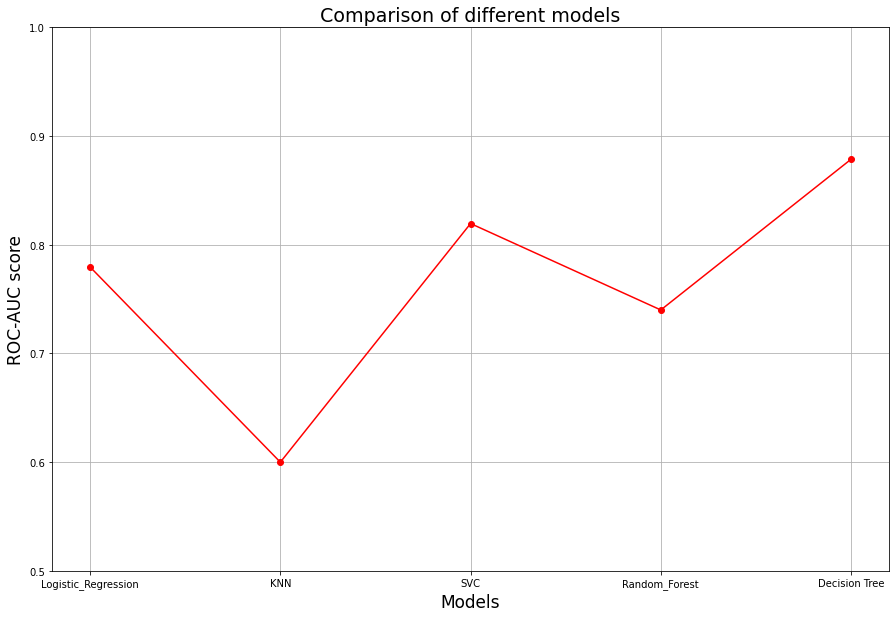

In [26]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score, marker = 'o', color = 'red')
plt.title('Comparison of different models',fontsize = 19)
plt.xlabel('Models', fontsize = 17)
plt.ylabel('ROC-AUC score',fontsize = 17)
plt.ylim(0.5, 1.0)
plt.grid()
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16) 
plt.savefig('Model_compare.jpeg')
plt.show()

## Crearting a Fraudulent Job Filter Using DecisionTreeClassifier



In [27]:
#Training and testing Decision tree classifier/ Fruadulent job filter using 0.5 split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(features, target, test_size = 0.5, stratify = target, random_state=42)

from sklearn.tree import DecisionTreeClassifier

Tree_filter = DecisionTreeClassifier(criterion = 'entropy')

#Training the model
Tree_filter.fit(X_train_f, y_train_f)

#Predicting
pred = Tree_filter.predict(X_test_f)

# X_test_f.columns
X_test_f['pred'] = pred

#dataset containing only non-fraudulent job postings which we will use for recommending
filtered_df = X_test_f[X_test_f["pred"].eq(0)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [28]:
NonFraud_job = filtered_df.drop("pred", axis = 1)

In [29]:
#Copy of non-fraudulent postings
NonFraud_job.to_csv("Filtered_jobs.csv")

In [30]:
NF = NonFraud_job.drop(["telecommuting", "has_company_logo", "has_questions" , ":)", ""], axis = 1)

In [31]:
NF.drop(NF.columns[[0]], axis = 1, inplace = True) 
my_list = NF.columns.values.tolist()
final_text = []
for index, row in NF.iterrows(): 
    temp = ''
    for i in range(len(my_list)):
        if row[i] >= 1:
            temp += str(my_list[i]) + ' '
    final_text.append(temp)
NF['text'] = final_text


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [32]:
final_df = NF['text']
df = pd.DataFrame(final_df)

 series = df.index  
df.insert(0, "Job_ID", series) 

# Recommendation system

In [33]:
#reading User Resume
MY_TEXT = docx2txt.process("/content/User_Resume.docx")

# User Resume Pre-Processing

In [34]:
words = MY_TEXT.split()
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in words]

In [35]:
stripped = [s.lower() for s in stripped]

In [36]:
stripped = [w for w in stripped if not w in stopwords]

In [37]:
user_resume = " ".join(stripped)

In [38]:
temp = []
temp.append(user_resume)

In [39]:
df_user = pd.DataFrame()

df_user["text"] = temp
df_user["ApplicantID"] = 1

In [40]:
df_user.head()

,text,ApplicantID
0,dhanalaxmi sangole ph 9162829259 email id samv...,1


In [41]:
df.dropna()

,Job_ID,text
5165,5165,'s 2 2 years ability able achieve based basis ...
3541,3541,tefl tefl tesol 200 200 cost abroad abroad :...
5279,5279,2 2 years agencies applications based candidat...
4561,4561,'s 1 100 5 5 years ability able amazing amp an...
2138,2138,'s 30 activities additional amp assigned atten...
...,...,...
8863,8863,'s ability ability work able access account ac...
10315,10315,'s 2 2 years 5 ability able and/or assist atte...
5980,5980,2 agency available business calls candidate ca...
1379,1379,ability account activities agencies agency bet...


In [42]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

#fitting and transforming the vector on Jon Posting Dataset
tfidf_jobid = tfidf_vectorizer.fit_transform((df['text'])) 

In [43]:
op = df_user.dropna()

In [44]:
user_tfidf = tfidf_vectorizer.transform(op['text'])

#Finding relevant jobs using Cosine Similarity

In [45]:
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)
output2 = list(cos_similarity_tfidf)

In [46]:
df_first = pd.read_csv('/content/fake_job_postings.csv')
df_first = df_first.sort_values('title').reset_index(drop = True)

In [47]:
def get_recommendation(top, df_all, scores):
  recommendation = pd.DataFrame(columns = ['Job_ID', 'Title', 'Location', 'Department', 'Company Profile',
                                           'Description', 'Requirement', 'Employment Type','Experience',
                                            'Education', 'Industry', 'Function', 'Fraudulent', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'Job_ID'] = df_first['job_id'].iloc[i]
      recommendation.at[count, 'Title'] = df_first['title'].iloc[i]
      recommendation.at[count, 'Location'] = df_first['location'].iloc[i]
      recommendation.at[count, 'Department'] = df_first['department'].iloc[i]
      recommendation.at[count, 'Company Profile'] = df_first['company_profile'].iloc[i]
      recommendation.at[count, 'Description'] = df_first['description'].iloc[i]
      recommendation.at[count, 'Requirement'] = df_first['requirements'].iloc[i]
      recommendation.at[count, 'Employment Type'] = df_first['employment_type'].iloc[i]
      recommendation.at[count, 'Experience'] = df_first['required_experience'].iloc[i]
      recommendation.at[count, 'Education'] = df_first['required_education'].iloc[i]
      recommendation.at[count, 'Industry'] = df_first['industry'].iloc[i]
      recommendation.at[count, 'Function'] = df_first['function'].iloc[i]
      recommendation.at[count, 'Fraudulent'] = df_first['fraudulent'].iloc[i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
results = get_recommendation(top, df, list_scores)

In [48]:
results.head()

,Job_ID,Title,Location,Department,Company Profile,Description,Requirement,Employment Type,Experience,Education,Industry,Function,Fraudulent,score
0,7935,Electrical Maintenance Technician,"US, GA, Atlanta",NaN,We Provide Full Time Permanent Positions for m...,(We have more than 1500+ Job openings in our w...,NaN,Full-time,NaN,NaN,NaN,NaN,0,0.422575
1,3157,Digital Media Sales Representative,"US, FL, Miami",Sales,Applied Memetics LLC is a professional service...,"Applied Memetics LLC (""AM LLC"") is looking for...",The Digital Media sales representative is acco...,Full-time,Associate,Bachelor's Degree,Broadcast Media,Sales,0,0.412562
2,6858,Business Development Manager - Banking & Inves...,"CH, GE,",NaN,PROFILE provides leading technology solutions ...,PROFILE is a world-class provider of Banking a...,The candidate should have the following charac...,Full-time,Mid-Senior level,NaN,Computer Software,Business Development,0,0.408419
3,15567,Developers Community Ace,"US, CA, San Francisco",NaN,"Mashape is the largest, most trafficked API ma...",You serve as the liaison between the company a...,You understand and love technologyOutstanding ...,Full-time,Not Applicable,NaN,Internet,Information Technology,0,0.380883
4,10683,Care Coordinator,"US, CA, Fresno",NaN,HealthCare California is a locally-owned and o...,Manages the scheduling for all patient admitte...,High School Diploma or equivalentDocumented co...,Full-time,NaN,NaN,Hospital & Health Care,NaN,0,0.36152


In [49]:
results.to_csv("Recommended_jobs.csv")